Step 1: Loading Dataset and Preprocessing it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/instance_version/

/content/drive/MyDrive/instance_version


In [ ]:
import json

with open("instances_train_trashcan.json") as f:
    train_data = json.load(f)

with open("instances_val_trashcan.json") as f:
    val_data = json.load(f)

print("Top-level keys:", train_data.keys())
print("Top-level keys:", val_data.keys())

Top-level keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
Top-level keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


The datasest is currently in COCO format. To use YOLO models, we need to convert into YOLO and made an appropiate directory structure for YOLO.

In [ ]:
import os
import json
from tqdm import tqdm
from PIL import Image
from pycocotools.coco import COCO

def convert_coco_to_yolo(coco_json_path, images_dir, output_labels_dir):
    os.makedirs(output_labels_dir, exist_ok=True)

    coco = COCO(coco_json_path)
    img_id_to_filename = {img['id']: img['file_name'] for img in coco.dataset['images']}
    img_id_to_size = {img['id']: (img['width'], img['height']) for img in coco.dataset['images']}

    for ann in tqdm(coco.dataset['annotations']):
        img_id = ann['image_id']
        category_id = ann['category_id'] - 1  # YOLO format uses 0-based index
        bbox = ann['bbox']  # [x_min, y_min, width, height]

        x, y, w, h = bbox
        img_width, img_height = img_id_to_size[img_id]

        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        w /= img_width
        h /= img_height

        # Build annotation line
        annotation_line = f"{category_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n"

        # Write to label file
        img_filename = img_id_to_filename[img_id]
        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        label_path = os.path.join(output_labels_dir, label_filename)

        with open(label_path, 'a') as f:
            f.write(annotation_line)

    print("✅ Conversion complete!")

# Example usage
convert_coco_to_yolo(
    coco_json_path="instances_train_trashcan.json",
    images_dir="/instance_version/train",
    output_labels_dir="/content/yolo_dataset/labels/train"
)

convert_coco_to_yolo(
    coco_json_path="instances_val_trashcan.json",
    images_dir="/instance_version/val",
    output_labels_dir="/content/yolo_dataset/labels/val"
)


loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


100%|██████████| 9540/9540 [00:01<00:00, 8977.02it/s]


✅ Conversion complete!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


100%|██████████| 2588/2588 [00:00<00:00, 9233.11it/s]

✅ Conversion complete!


Step 3: Checking Number of Images in both training set and validation set to verify.

In [ ]:
train_images = train_data['images']
val_images = val_data['images']
train_annotations = train_data['annotations']
val_annotations = val_data['annotations']
categories = train_data['categories']

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Training annotations: {len(train_annotations)}")
print(f"Validation annotations: {len(val_annotations)}")
print(f"Number of categories: {len(categories)}")

Training images: 6065
Validation images: 1147
Training annotations: 9540
Validation annotations: 2588
Number of categories: 22


Copying images to a yolo compatible folder

In [ ]:
import shutil
import os

# Create image dirs
os.makedirs("/content/yolo_dataset/images/train", exist_ok=True)
os.makedirs("/content/yolo_dataset/images/val", exist_ok=True)

# Paths to your original images
train_imgs = "/content/drive/MyDrive/instance_version/train"
val_imgs = "/content/drive/MyDrive/instance_version/val"

# Copy images
for fname in os.listdir(train_imgs):
    if fname.endswith(".jpg"):
        shutil.copy(os.path.join(train_imgs, fname), "/content/yolo_dataset/images/train")

for fname in os.listdir(val_imgs):
    if fname.endswith(".jpg"):
        shutil.copy(os.path.join(val_imgs, fname), "/content/yolo_dataset/images/val")

This graph displays a bar chart illustrating the class distribution within a training dataset. It visually represents the annotation count for various categories, indicating how frequently each class appears in the dataset.

Checking Number of images in new folder to make sure all images are successfully copied or not

In [ ]:
import os

# Path to your training images
train_image_dir = '/content/yolo_dataset/images/train'
val_image_dir = '/content/yolo_dataset/images/val'

# Count the number of images (assuming .jpg, .png, etc.)
image_file1 = [f for f in os.listdir(train_image_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
num_images1 = len(image_file1)

image_file2 = [f for f in os.listdir(val_image_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
num_images2 = len(image_file2)

print(f"Number of images in the training set new folder: {num_images1}")
print(f"Number of images in the validation set new folder: {num_images2}")

Number of images in the training set new folder: 6065
Number of images in the validation set new folder: 1147


Data Cleaning. Checking Corrupted Files.
After applying normalization on bounding boxes. Some bounding boxes values still exceed greater than 1 so we will apply renormalization.

In [ ]:
import os
from glob import glob

def check_labels(label_dir):
    bad_files = []
    for label_file in glob(f"{label_dir}/**/*.txt", recursive=True):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    bad_files.append(label_file)
                    break
                coords = list(map(float, parts[1:]))
                if any(c < 0 or c > 1 for c in coords):
                    bad_files.append(label_file)
                    break
    return list(set(bad_files))

bad_labels = check_labels("/content/yolo_dataset/labels/val")
print(f"Found {len(bad_labels)} corrupted label files:")

Found 52 corrupted label files:


In [ ]:
from PIL import Image

def renormalize_label_file(label_path, images_dir):
    img_name = os.path.basename(label_path).replace(".txt", ".jpg")
    img_path = os.path.join(images_dir, img_name)

    if not os.path.exists(img_path):
        print(f"⚠️ Image not found for: {label_path}")
        return

    with Image.open(img_path) as img:
        img_width, img_height = img.size

    fixed_lines = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            cls, x, y, w, h = parts
            try:
                x, y, w, h = map(float, [x, y, w, h])
            except:
                continue

            # Denormalize and re-normalize (with clamping)
            x_pixel = x * img_width
            y_pixel = y * img_height
            w_pixel = w * img_width
            h_pixel = h * img_height

            x_new = min(max(x_pixel / img_width, 0), 1)
            y_new = min(max(y_pixel / img_height, 0), 1)
            w_new = min(max(w_pixel / img_width, 0), 1)
            h_new = min(max(h_pixel / img_height, 0), 1)

            fixed_lines.append(f"{cls} {x_new:.6f} {y_new:.6f} {w_new:.6f} {h_new:.6f}\n")

    # Save fixed label file
    with open(label_path, 'w') as f:
        f.writelines(fixed_lines)


for label_path in bad_labels:
    renormalize_label_file(label_path, "/content/yolo_dataset/images/val")

Verifiying images in Validation Set

In [ ]:
import os
from glob import glob

def check_labels(label_dir):
    bad_files = []
    for label_file in glob(f"{label_dir}/**/*.txt", recursive=True):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    bad_files.append(label_file)
                    break
                coords = list(map(float, parts[1:]))
                if any(c < 0 or c > 1 for c in coords):
                    bad_files.append(label_file)
                    break
    return list(set(bad_files))

bad_labels = check_labels("/content/yolo_dataset/labels/val")
print(f"Found {len(bad_labels)} corrupted label files:")

Found 0 corrupted label files:


In [ ]:
import os
from glob import glob

def check_labels(label_dir):
    bad_files = []
    for label_file in glob(f"{label_dir}/**/*.txt", recursive=True):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    bad_files.append(label_file)
                    break
                coords = list(map(float, parts[1:]))
                if any(c < 0 or c > 1 for c in coords):
                    bad_files.append(label_file)
                    break
    return list(set(bad_files))

bad_labels = check_labels("/content/yolo_dataset/labels/train")
print(f"Found {len(bad_labels)} corrupted label files:")

Found 325 corrupted label files:


In [ ]:
from PIL import Image

def renormalize_label_file(label_path, images_dir):
    img_name = os.path.basename(label_path).replace(".txt", ".jpg")
    img_path = os.path.join(images_dir, img_name)

    if not os.path.exists(img_path):
        print(f"⚠️ Image not found for: {label_path}")
        return

    with Image.open(img_path) as img:
        img_width, img_height = img.size

    fixed_lines = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            cls, x, y, w, h = parts
            try:
                x, y, w, h = map(float, [x, y, w, h])
            except:
                continue

            # Denormalize and re-normalize (with clamping)
            x_pixel = x * img_width
            y_pixel = y * img_height
            w_pixel = w * img_width
            h_pixel = h * img_height

            x_new = min(max(x_pixel / img_width, 0), 1)
            y_new = min(max(y_pixel / img_height, 0), 1)
            w_new = min(max(w_pixel / img_width, 0), 1)
            h_new = min(max(h_pixel / img_height, 0), 1)

            fixed_lines.append(f"{cls} {x_new:.6f} {y_new:.6f} {w_new:.6f} {h_new:.6f}\n")

    # Save fixed label file
    with open(label_path, 'w') as f:
        f.writelines(fixed_lines)


for label_path in bad_labels:
    renormalize_label_file(label_path, "/content/yolo_dataset/images/train")

Verifying images in Training Set

In [ ]:
import os
from glob import glob

def check_labels(label_dir):
    bad_files = []
    for label_file in glob(f"{label_dir}/**/*.txt", recursive=True):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    bad_files.append(label_file)
                    break
                coords = list(map(float, parts[1:]))
                if any(c < 0 or c > 1 for c in coords):
                    bad_files.append(label_file)
                    break
    return list(set(bad_files))

bad_labels = check_labels("/content/yolo_dataset/labels/train")
print(f"Found {len(bad_labels)} corrupted label files:")

Found 0 corrupted label files:


In [ ]:
import os

label_dir = '/content/yolo_dataset/labels/train'

for filename in os.listdir(label_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(label_dir, filename), 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                bbox = [float(x) for x in parts[1:]]  # Skip class_id
                if not all(0 <= val <= 1 for val in bbox):
                    print(f"⚠️ Out-of-bounds bbox in {filename}: {bbox}")
print("✅ Done checking all labels.")


✅ Done checking all labels.


The below bar chart displays the class distribution within a training dataset. It visually represents the annotation count for various categories, indicating how frequently each class appears in the dataset.

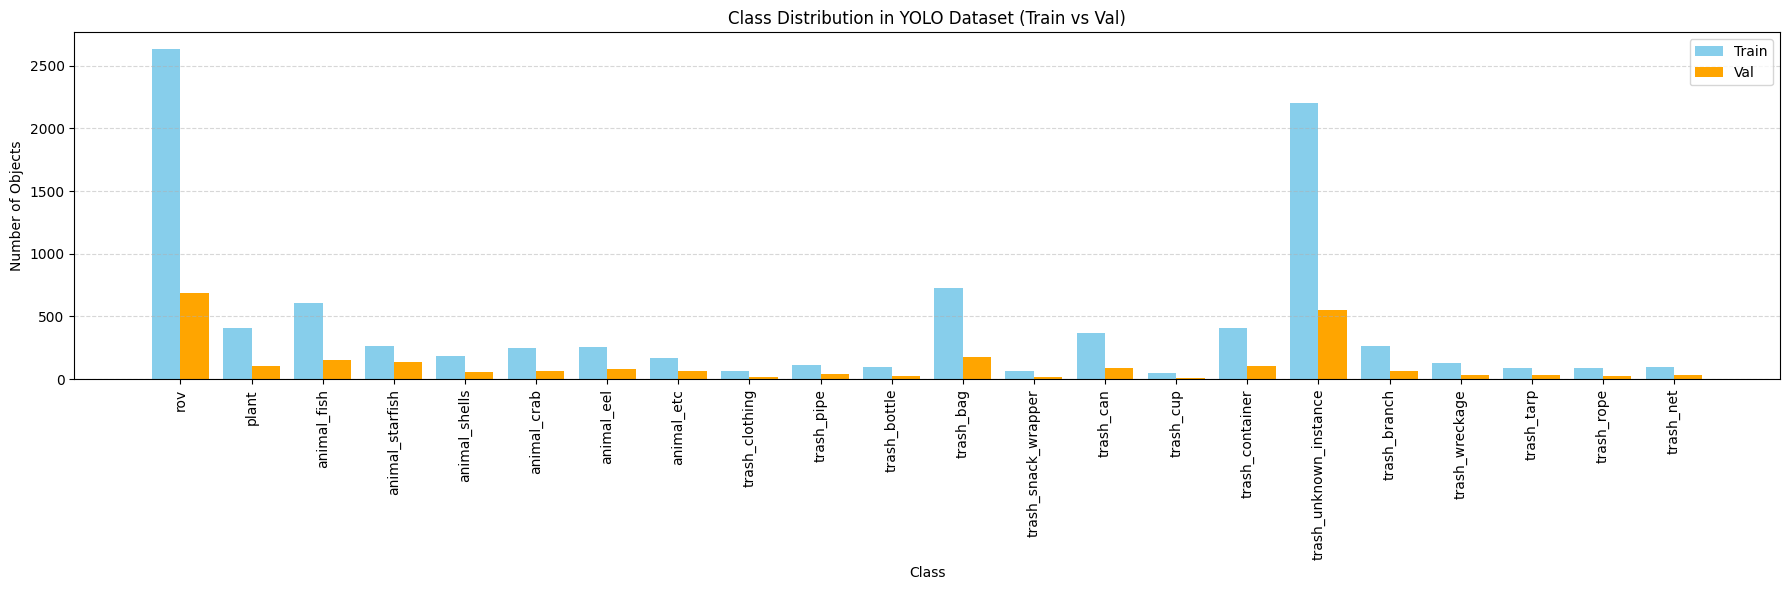

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

train_labels_dir = "/content/yolo_dataset/labels/train"
val_labels_dir = "/content/yolo_dataset/labels/val"


class_names = [
    'rov', 'plant', 'animal_fish', 'animal_starfish', 'animal_shells', 'animal_crab',
    'animal_eel', 'animal_etc', 'trash_clothing', 'trash_pipe', 'trash_bottle',
    'trash_bag', 'trash_snack_wrapper', 'trash_can', 'trash_cup', 'trash_container',
    'trash_unknown_instance', 'trash_branch', 'trash_wreckage', 'trash_tarp',
    'trash_rope', 'trash_net'
]

# 📊 Count YOLO labels per class
def count_classes(label_dir):
    class_counts = Counter()
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file), 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        class_counts[class_id] += 1
    return class_counts


train_counts = count_classes(train_labels_dir)
val_counts = count_classes(val_labels_dir)


train_freq = [train_counts.get(i, 0) for i in range(len(class_names))]
val_freq = [val_counts.get(i, 0) for i in range(len(class_names))]

# 📈 Plot side-by-side bar chart
x = np.arange(len(class_names))
width = 0.4

plt.figure(figsize=(18, 6))
plt.bar(x - width/2, train_freq, width, label='Train', color='skyblue')
plt.bar(x + width/2, val_freq, width, label='Val', color='orange')
plt.xticks(x, class_names, rotation=90)
plt.xlabel("Class")
plt.ylabel("Number of Objects")
plt.title("Class Distribution in YOLO Dataset (Train vs Val)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Scanning for label files in: /content/yolo_dataset/labels/train
Found 5936 label files. Counting class instances...

Final Class Counts:
- rov: 2633
- plant: 405
- animal_fish: 611
- animal_starfish: 262
- animal_shells: 188
- animal_crab: 246
- animal_eel: 259
- animal_etc: 170
- trash_clothing: 65
- trash_pipe: 114
- trash_bottle: 100
- trash_bag: 727
- trash_snack_wrapper: 67
- trash_can: 366
- trash_cup: 47
- trash_container: 407
- trash_unknown_instance: 2203
- trash_branch: 268
- trash_wreckage: 130
- trash_tarp: 90
- trash_rope: 88
- trash_net: 94

Generating plot...


/tmp/ipython-input-16-2077410194.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts, y=class_names, palette='viridis', orient='h')


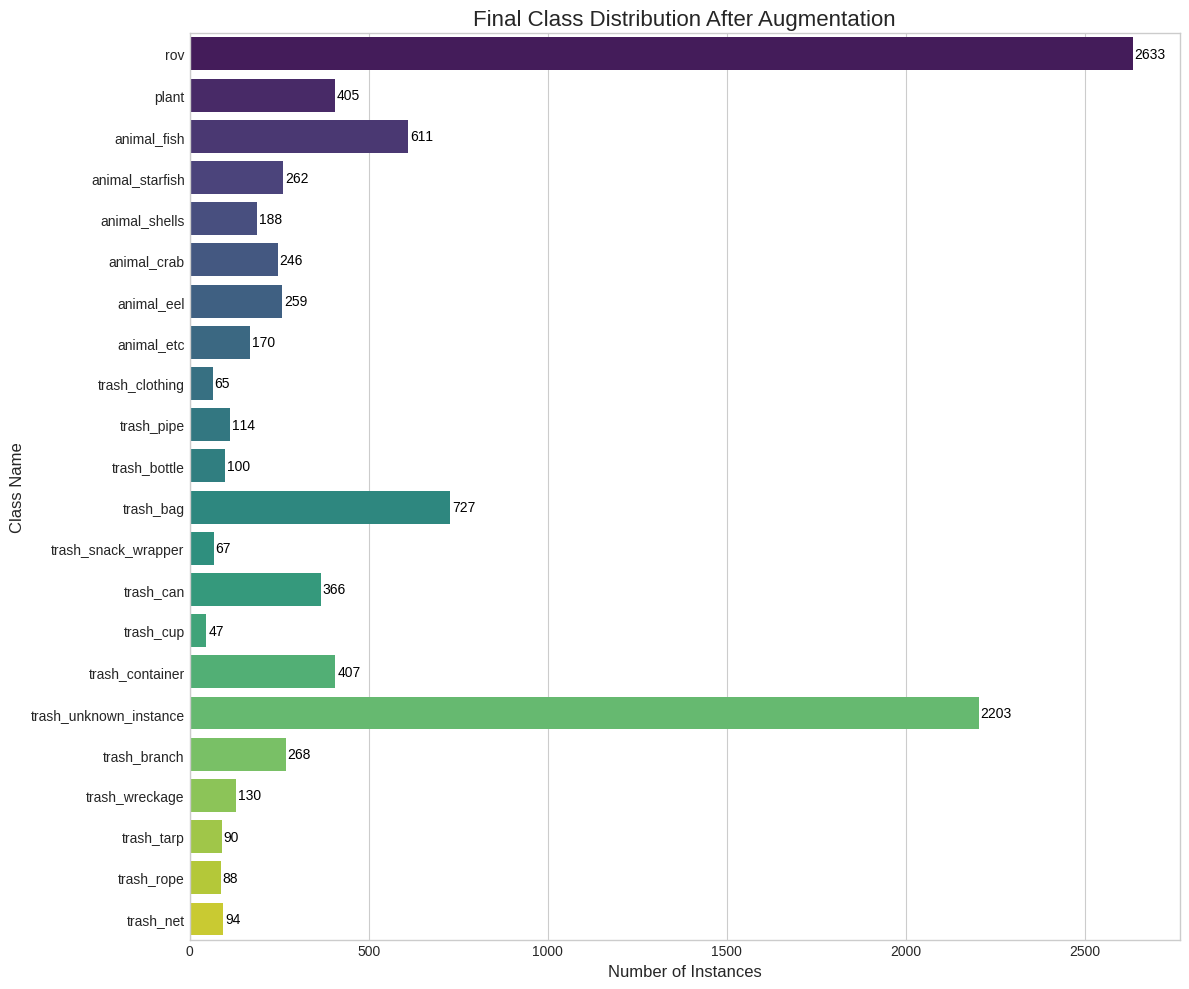

In [ ]:
import os
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Before Augmentation
LABEL_DIR = '/content/yolo_dataset/labels/train'

# Use the same class list as your training script for consistency.
CLASS_LIST = [
    'rov', 'plant', 'animal_fish', 'animal_starfish', 'animal_shells',
    'animal_crab', 'animal_eel', 'animal_etc',
    'trash_clothing', 'trash_pipe', 'trash_bottle', 'trash_bag',
    'trash_snack_wrapper', 'trash_can', 'trash_cup', 'trash_container',
    'trash_unknown_instance', 'trash_branch', 'trash_wreckage',
    'trash_tarp', 'trash_rope', 'trash_net'
]

# --- Helper Function ---
def read_yolo_labels(label_path):
    """Reads class IDs from a single YOLO label file."""
    class_ids = []
    try:
        with open(label_path, 'r') as f:
            lines = f.read().splitlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) > 0:
                # --- FIX: Convert to float first, then to int ---
                # This handles class IDs that might be written as '21.0' instead of '21'.
                class_ids.append(int(float(parts[0])))
    except Exception as e:
        print(f"Could not read or process {label_path}: {e}")
    return class_ids

# --- Main Script ---
def plot_class_distribution():
    """
    Counts all class instances in the label directory and plots a bar graph.
    """
    print(f"Scanning for label files in: {LABEL_DIR}")
    label_files = glob(os.path.join(LABEL_DIR, '*.txt'))

    if not label_files:
        print("Error: No label files found in the specified directory.")
        return

    print(f"Found {len(label_files)} label files. Counting class instances...")

    # Count all instances of each class ID
    class_counts = defaultdict(int)
    for label_path in label_files:
        class_ids = read_yolo_labels(label_path)
        for cls_id in class_ids:
            if cls_id < len(CLASS_LIST):
                class_counts[cls_id] += 1
            else:
                print(f"Warning: Found an invalid class ID '{cls_id}' in {os.path.basename(label_path)}")

    if not class_counts:
        print("Error: Could not find any class instances in the label files.")
        return

    # Prepare data for plotting
    # Sort by class ID to maintain a consistent order
    sorted_class_ids = sorted(class_counts.keys())

    class_names = [CLASS_LIST[i] for i in sorted_class_ids]
    counts = [class_counts[i] for i in sorted_class_ids]

    print("\nFinal Class Counts:")
    for name, count in zip(class_names, counts):
        print(f"- {name}: {count}")

    # --- Plotting ---
    print("\nGenerating plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10)) # Adjusted size for better readability

    # Create a horizontal bar plot
    ax = sns.barplot(x=counts, y=class_names, palette='viridis', orient='h')

    # Add count labels to the end of each bar
    for i, count in enumerate(counts):
        ax.text(count + 5, i, str(count), color='black', va='center')

    # Set titles and labels for clarity
    plt.title('Final Class Distribution After Augmentation', fontsize=16)
    plt.xlabel('Number of Instances', fontsize=12)
    plt.ylabel('Class Name', fontsize=12)

    # Adjust layout to prevent labels from being cut off
    plt.tight_layout()

    # Display the plot
    plt.show()


# Run the plotting function
if __name__ == '__main__':
    plot_class_distribution()


In [ ]:
import os
import cv2
import random
from glob import glob
from collections import defaultdict
import albumentations as A
import numpy as np

# --- Configuration ---
# Ensure these paths are correct for your environment
IMAGE_DIR = '/content/yolo_dataset/images/train'
LABEL_DIR = '/content/yolo_dataset/labels/train'
TARGET_PER_CLASS = 750
AUG_PER_IMAGE = 5

# Classes to target for augmentation
UNDERREP_CLASSES = [
    'trash_cup', 'trash_clothing', 'trash_snack_wrapper',
    'trash_tarp', 'trash_rope', 'trash_net',
    'trash_pipe', 'trash_bottle'
]

# Full list of classes in the dataset
CLASS_LIST = [
    'rov', 'plant', 'animal_fish', 'animal_starfish', 'animal_shells',
    'animal_crab', 'animal_eel', 'animal_etc',
    'trash_clothing', 'trash_pipe', 'trash_bottle', 'trash_bag',
    'trash_snack_wrapper', 'trash_can', 'trash_cup', 'trash_container',
    'trash_unknown_instance', 'trash_branch', 'trash_wreckage',
    'trash_tarp', 'trash_rope', 'trash_net'
]
CLASS_NAME_TO_ID = {name: idx for idx, name in enumerate(CLASS_LIST)}

# --- Helper Functions ---
def read_yolo_labels(label_path):
    """Reads YOLO format labels from a file."""
    objects = []
    try:
        with open(label_path, 'r') as f:
            lines = f.read().splitlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            objects.append((cls_id, bbox))
    except FileNotFoundError:
        print(f"Warning: Label file not found: {label_path}")
    return objects

def write_yolo_labels(label_path, objects):
    """Writes a list of objects to a YOLO format label file."""
    with open(label_path, 'w') as f:
        for cls_id, bbox in objects:
            # Ensure coordinates are rounded for clean output
            bbox_str = ' '.join(map(lambda x: f'{x:.6f}', bbox))
            f.write(f"{cls_id} {bbox_str}\n")

# --- Initial Class Count ---
print("Counting initial class frequencies...")
class_counts = defaultdict(int)
label_files = glob(os.path.join(LABEL_DIR, '*.txt'))

for label_path in label_files:
    for cls_id, _ in read_yolo_labels(label_path):
        class_counts[cls_id] += 1

print("Initial counts:", dict(sorted(class_counts.items())))


# --- Albumentations Pipeline ---
# This pipeline defines the augmentations that will be applied.
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    # Affine can cause bboxes to go out of bounds, which raises errors.
    # The script will handle this with a try-except block.
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), rotate=(-10, 10), p=0.7),
    A.MotionBlur(p=0.2),
], bbox_params=A.BboxParams(format='yolo',
                            label_fields=['class_labels'],
                            # Remove boxes that are mostly outside the image after transform
                            min_visibility=0.25,
                            ))


# --- Augmentation Process ---
print("\nStarting augmentation process...")
aug_idx = 0
# Iterate over a copy of the file list, as we will be adding new files to the directory
for label_path in list(label_files):
    # Construct the corresponding image path, checking for both .jpg and .png
    base_filename = os.path.basename(label_path).replace('.txt', '')
    image_path_jpg = os.path.join(IMAGE_DIR, base_filename + '.jpg')
    image_path_png = os.path.join(IMAGE_DIR, base_filename + '.png')

    if os.path.exists(image_path_jpg):
        image_path = image_path_jpg
    elif os.path.exists(image_path_png):
        image_path = image_path_png
    else:
        print(f"Warning: No corresponding image found for label {label_path}")
        continue

    # Read the original image and its labels
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        continue

    # Albumentations requires BGR images to be converted to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    objects = read_yolo_labels(label_path)
    if not objects:
        continue


    # An image should be augmented if it contains ANY underrepresented class
    # that is still below the target count.
    image_needs_augmenting = False
    for cls_id, _ in objects:
        class_name = CLASS_LIST[cls_id]
        if class_name in UNDERREP_CLASSES and class_counts[cls_id] < TARGET_PER_CLASS:
            image_needs_augmenting = True
            break # Found a class that needs augmenting, no need to check more

    if not image_needs_augmenting:
        continue

    #Prepare ALL bboxes from the image for transformation ---
    original_bboxes = [bbox for _, bbox in objects]
    original_class_labels = [cls_id for cls_id, _ in objects]

    # Generate N augmentations for this image
    for _ in range(AUG_PER_IMAGE):
        try:
            # --- ERROR FIX: Pass ALL bboxes and labels to the transform ---
            augmented = transform(image=image, bboxes=original_bboxes, class_labels=original_class_labels)

            aug_image = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_classes = augmented['class_labels']

            # If augmentation removed all bboxes, skip saving this one
            if not aug_bboxes:
                continue

            # --- ERROR FIX: Process and clean the output from the transform ---
            new_objects = []
            for cls_id, bbox in zip(aug_classes, aug_bboxes):
                # Albumentations can return bboxes slightly outside [0,1].
                # We must clip them to be valid.
                x_c, y_c, w, h = bbox

                # Clip coordinates to the valid [0.0, 1.0] range
                x_c = np.clip(x_c, 0.0, 1.0)
                y_c = np.clip(y_c, 0.0, 1.0)
                w = np.clip(w, 0.0, 1.0)
                h = np.clip(h, 0.0, 1.0)

                # Ensure the box is valid after clipping (has area and is within bounds)
                if w > 0 and h > 0 and (x_c + w/2 <= 1.0) and (x_c - w/2 >= 0.0) and (y_c + h/2 <= 1.0) and (y_c - h/2 >= 0.0):
                    new_objects.append((cls_id, [x_c, y_c, w, h]))

            if not new_objects:
                continue

            # Save the new augmented image and its label file
            name, ext = os.path.splitext(os.path.basename(image_path))
            aug_filename = f"{name}_aug{aug_idx}{ext}"
            aug_labelname = f"{name}_aug{aug_idx}.txt"

            # Convert image back to BGR for saving with OpenCV
            aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(IMAGE_DIR, aug_filename), aug_image_bgr)
            write_yolo_labels(os.path.join(LABEL_DIR, aug_labelname), new_objects)

            # Update the counts for all classes in the newly created file
            for cls_id, _ in new_objects:
                class_counts[cls_id] += 1
            aug_idx += 1

        except ValueError as e:
            # --- ERROR FIX: Catch the error to prevent the script from crashing ---
            # This can happen if a transform results in an unrecoverable state.

            continue

print(f"\n Augmentation complete. {aug_idx} new files added.")
print("Final counts:", dict(sorted(class_counts.items())))


Counting initial class frequencies...
Initial counts: {0: 2633, 1: 405, 2: 611, 3: 262, 4: 188, 5: 246, 6: 259, 7: 170, 8: 65, 9: 114, 10: 100, 11: 727, 12: 67, 13: 366, 14: 47, 15: 407, 16: 2203, 17: 268, 18: 130, 19: 90, 20: 88, 21: 94}

Starting augmentation process...

✅ Augmentation complete. 1822 new files added.
Final counts: {0: 2774, 1: 410, 2: 611, 3: 262, 4: 280, 5: 298, 6: 259, 7: 170, 8: 245, 9: 532, 10: 444, 11: 806, 12: 240, 13: 366, 14: 223, 15: 477, 16: 2373, 17: 278, 18: 130, 19: 337, 20: 352, 21: 159}


Scanning for label files in: /content/yolo_dataset/labels/train
Found 7758 label files. Counting class instances...

Final Class Counts:
- rov: 2774
- plant: 410
- animal_fish: 611
- animal_starfish: 262
- animal_shells: 280
- animal_crab: 298
- animal_eel: 259
- animal_etc: 170
- trash_clothing: 245
- trash_pipe: 532
- trash_bottle: 444
- trash_bag: 806
- trash_snack_wrapper: 240
- trash_can: 366
- trash_cup: 223
- trash_container: 477
- trash_unknown_instance: 2373
- trash_branch: 278
- trash_wreckage: 130
- trash_tarp: 337
- trash_rope: 352
- trash_net: 159

Generating plot...


/tmp/ipython-input-19-3452203101.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts, y=class_names, palette='viridis', orient='h')


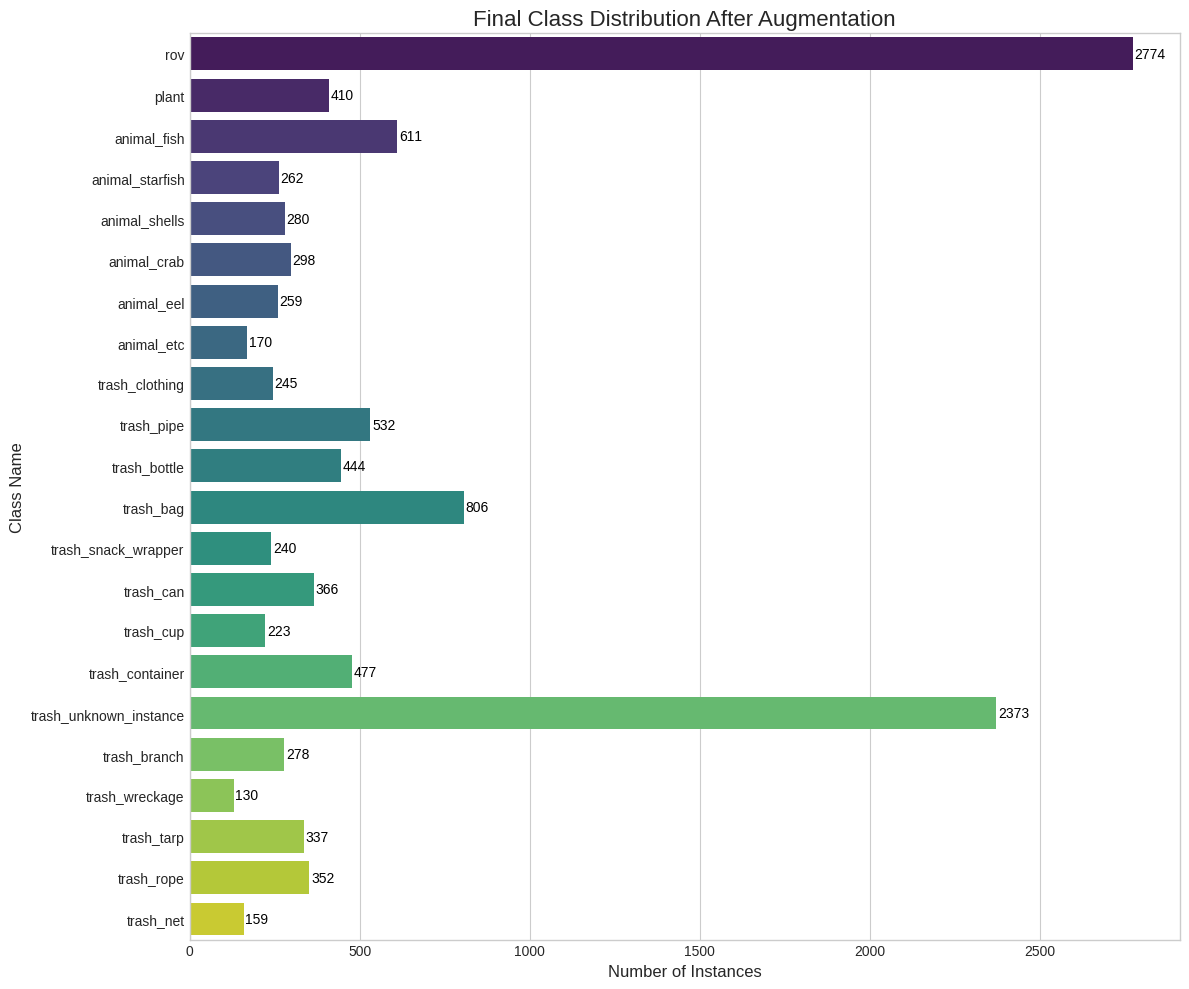

In [ ]:
import os
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
# IMPORTANT: Use the same directory where your final labels (original + augmented) are.
LABEL_DIR = '/content/yolo_dataset/labels/train'

# Use the same class list as your training script for consistency.
CLASS_LIST = [
    'rov', 'plant', 'animal_fish', 'animal_starfish', 'animal_shells',
    'animal_crab', 'animal_eel', 'animal_etc',
    'trash_clothing', 'trash_pipe', 'trash_bottle', 'trash_bag',
    'trash_snack_wrapper', 'trash_can', 'trash_cup', 'trash_container',
    'trash_unknown_instance', 'trash_branch', 'trash_wreckage',
    'trash_tarp', 'trash_rope', 'trash_net'
]

# --- Helper Function ---
def read_yolo_labels(label_path):
    """Reads class IDs from a single YOLO label file."""
    class_ids = []
    try:
        with open(label_path, 'r') as f:
            lines = f.read().splitlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) > 0:
                # --- FIX: Convert to float first, then to int ---
                # This handles class IDs that might be written as '21.0' instead of '21'.
                class_ids.append(int(float(parts[0])))
    except Exception as e:
        print(f"Could not read or process {label_path}: {e}")
    return class_ids

# --- Main Script ---
def plot_class_distribution():
    """
    Counts all class instances in the label directory and plots a bar graph.
    """
    print(f"Scanning for label files in: {LABEL_DIR}")
    label_files = glob(os.path.join(LABEL_DIR, '*.txt'))

    if not label_files:
        print("Error: No label files found in the specified directory.")
        return

    print(f"Found {len(label_files)} label files. Counting class instances...")

    # Count all instances of each class ID
    class_counts = defaultdict(int)
    for label_path in label_files:
        class_ids = read_yolo_labels(label_path)
        for cls_id in class_ids:
            if cls_id < len(CLASS_LIST):
                class_counts[cls_id] += 1
            else:
                print(f"Warning: Found an invalid class ID '{cls_id}' in {os.path.basename(label_path)}")

    if not class_counts:
        print("Error: Could not find any class instances in the label files.")
        return

    # Prepare data for plotting
    # Sort by class ID to maintain a consistent order
    sorted_class_ids = sorted(class_counts.keys())

    class_names = [CLASS_LIST[i] for i in sorted_class_ids]
    counts = [class_counts[i] for i in sorted_class_ids]

    print("\nFinal Class Counts:")
    for name, count in zip(class_names, counts):
        print(f"- {name}: {count}")

    # --- Plotting ---
    print("\nGenerating plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10)) # Adjusted size for better readability

    # Create a horizontal bar plot
    ax = sns.barplot(x=counts, y=class_names, palette='viridis', orient='h')

    # Add count labels to the end of each bar
    for i, count in enumerate(counts):
        ax.text(count + 5, i, str(count), color='black', va='center')

    # Set titles and labels for clarity
    plt.title('Final Class Distribution After Augmentation', fontsize=16)
    plt.xlabel('Number of Instances', fontsize=12)
    plt.ylabel('Class Name', fontsize=12)

    # Adjust layout to prevent labels from being cut off
    plt.tight_layout()

    # Display the plot
    plt.show()


# Run the plotting function
if __name__ == '__main__':
    plot_class_distribution()


Verifying the Bounding boxes of the augmented images to make sure that the boxes are well aligned. Doing a Final Check.

In [ ]:
!pip install fiftyOne

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.3/306.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.0/943.0 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 7.5 MB/s eta 0:0

129 images will be skipped by YOLO models as they dont have any bounding boxes.

In [ ]:
import os
from glob import glob

image_dir = "/content/yolo_dataset/images/train"
label_dir = "/content/yolo_dataset/labels/train"

# Supported image extensions
image_paths = glob(os.path.join(image_dir, "*.jpg")) + glob(os.path.join(image_dir, "*.png"))

no_annotation_images = []

for img_path in image_paths:
    base = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(label_dir, base + ".txt")

    if not os.path.exists(label_path):
        no_annotation_images.append(img_path)
        continue

    with open(label_path, "r") as f:
        content = f.read().strip()
        if len(content) == 0:
            no_annotation_images.append(img_path)

print(f"Found {len(no_annotation_images)} images with no annotations.")



Found 129 images with no annotations.


In [ ]:
import fiftyone as fo
import fiftyone.types as fot

dataset = fo.Dataset.from_dir(
    dataset_dir="/content/yolo_dataset",     # root folder with images/ and labels/
    dataset_type=fot.YOLOv5Dataset,
    split="train",                            # folder under images/ and labels/
    name="underwater-trash-yolo"
)

session = fo.launch_app(dataset, remote=True)


 100% |███████████████| 7758/7758 [16.2s elapsed, 0s remaining, 472.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 7758/7758 [16.2s elapsed, 0s remaining, 472.5 samples/s]      


ValueError: Remote sessions cannot be run from a notebook

Creating yaml file which is necessary for training.

In [ ]:
yaml_content = """
train: /content/yolo_dataset/images/train
val: /content/yolo_dataset/images/val

nc: 22
names:
  - rov
  - plant
  - animal_fish
  - animal_starfish
  - animal_shells
  - animal_crab
  - animal_eel
  - animal_etc
  - trash_clothing
  - trash_pipe
  - trash_bottle
  - trash_bag
  - trash_snack_wrapper
  - trash_can
  - trash_cup
  - trash_container
  - trash_unknown_instance
  - trash_branch
  - trash_wreckage
  - trash_tarp
  - trash_rope
  - trash_net
"""

with open("/content/yolo_dataset/dataset.yaml", "w") as f:
    f.write(yaml_content)


Importing Cleaned and Augmented dataset which can be used for training.

In [ ]:
import shutil

shutil.make_archive("yolo_dataset", 'zip', "/content/yolo_dataset")


'/content/yolo_dataset.zip'

In [ ]:
from google.colab import files

files.download("/content/yolo_dataset.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>